人口の世代マップを動画にする。

In [1]:
import glob
import numpy
import pandas as pd
import geopandas as gpd
import sklearn.decomposition
import matplotlib
import matplotlib.animation
from shapely.geometry import Point
from matplotlib import pyplot as plt

In [2]:
import os.path
import re

In [3]:
import unittest
T = unittest.TestCase()

In [4]:
# 神戸市人口データ
def load_zensi(fname):
    ku_code = {
        "東灘区":"101",
        "灘区":  "102",
        "中央区":"110",
        "兵庫区":"105",
        "北区":  "109",
        "長田区":"106",
        "須磨区":"107",
        "北須磨":"107",
        "垂水区":"108",
        "西区"  :"111"}
    
    e = pd.ExcelFile(fname)
    zensi = os.path.basename(fname).startswith("zensi")
    skiprows = 2
    skiprows_content = 0
    ages=["%d～%d歳" % (i*5,i*5+4) for i in range(15)]+["80歳以上"]
    if zensi:
        skiprows = 1
        skiprows_content = 1
        ages=["%d歳" % i for i in range(100)]+["100歳以上"]
    
    dfs = []
    for s in e.sheet_names:
        if s in ("全市","神戸市","全世帯"):
            continue
        
        def str_strip(d):
            return str(d).strip()
        
        cv = {"区コード":str_strip, "町コード":str_strip, "町名":str_strip, "区・支所":str_strip}
        d = e.parse(s, skiprows=skiprows, converters=cv).iloc[skiprows_content:,:]
        d = d[d["町コード"].notnull()]
        if not zensi:
            m = re.match(r"^(\d{2})?(?P<ku>[^\d]+?)(\(再掲\))?$", s.strip())
            ku = "-"
            if m:
                ku = m.groupdict()["ku"]
                if ku == "須磨本区":
                    ku = "須磨区"
                d = d.assign(**{"区・支所" : ku})
            d_ = d["町コード"].apply(lambda s: ku_code[ku] + ("0"*(6-len(s))) + s)
            d = d.assign(**{"町コード":d_})
        dfs.append(d)
    return pd.DataFrame(pd.concat(dfs, ignore_index=True))[["町コード","区・支所", "町名"]+ages]

In [5]:
# e-Stat 区域データ
def load_estat(pattern):
    us = [gpd.read_file(f) for f in glob.glob(pattern)]
    pib_ = gpd.GeoDataFrame(pd.concat(us, ignore_index=True), crs=us[0].crs)
    pib = pib_[(pib_["MOJI"]!="水面") & (pib_["MOJI"].isnull()==False)] # 海上を取り除く
    return pib

In [6]:
def proc(zensi_name, estat_name):
    pib = load_estat(estat_name)
    data0 = load_zensi(zensi_name)
    
    meta = ["町名", "区・支所", "町コード"]
    ages = list(data0.columns)
    for m in meta:
        ages.remove(m)
    rgb = ["r","g","b"]

    data1 = data0.loc[data0[ages].dropna().index]
    
    m = sklearn.decomposition.NMF(3)
    o = m.fit_transform(data1[ages].values)

    qv = pd.DataFrame(m.components_.dot([i^2 for i in range(len(ages))])/ m.components_.sum(axis=1), columns=["sort_key"]).sort_values("sort_key", ascending=False)
    cc = ["rbg"[list(qv.index).index(i)] for i in range(m.n_components)]
    data2 = pd.concat([data1[meta], pd.DataFrame(o, index=data1.index, columns=cc)], axis=1)
    
    # 神戸市人口データに「KEYCODE1｝を追加する
    keycodes = set(pib["KEYCODE1"])

    # KEYCODE1 が存在しないものについて、Point を求める
    data3_ = data2[data2["町コード"].isin(keycodes)==False].apply(
        lambda r:"神戸市 %s %s" % (r["区・支所"].replace("支所",""), r["町名"]),
        axis=1
    ).rename("qname").to_frame().join(
        pd.read_json(open("../cache/kobe.json", encoding="UTF-8")).T,
        on="qname"
    )[["lat","lng"]].dropna().apply(
        lambda r:Point(r["lng"], r["lat"]),
        reduce=True,
        axis=1
    ).rename("geometry")
    
    # KEYCODE1 を揃えて求める
    data3_ = pd.concat([
        data2,
        gpd.tools.sjoin(gpd.GeoDataFrame(data3_, crs="+init=epsg:4326").to_crs(pib.crs), pib, op="within")["KEYCODE1"]
    ], axis=1).apply(
        lambda r:r["町コード"] if r["町コード"] in keycodes else r["KEYCODE1"],
        axis=1
    ).rename("KEYCODE1")

    data3 = pd.concat([data2, data3_], axis=1)
    print(data3.columns)
    
    dataLoss = data3[data3["KEYCODE1"].isnull()]
    print("FILE:", zensi_name, "UNHANDLED IN", dataLoss["町名"], )
    
    pib_pop_ = pib.join(
        pd.concat([pib.geometry.area, pib["KEYCODE1"]], axis=1).groupby("KEYCODE1").sum().rename(columns={0:"area_sum"}),
        on="KEYCODE1"
    ).join(
        data3.groupby("KEYCODE1").sum()[rgb],
        on="KEYCODE1"
    )
    pib_pop = pib_pop_.assign(
        **{k : pib_pop_[k].mul(pib_pop_.geometry.area / pib_pop_["area_sum"], axis=0) for k in rgb}
    ).fillna(0)
    for k in rgb:
        T.assertAlmostEqual( pib_pop.sum()[k], data3[data3["KEYCODE1"].notnull()].sum()[k] )

    dens = numpy.power(pib.geometry.area, -1/2) # gamma
    dens.name="dens"

    c2 = pd.DataFrame(sklearn.preprocessing.normalize(pib_pop[rgb]), index=pib.index, columns=rgb)
    def make_color(r):
        if r[rgb].sum()==0:
            return (1/3,1/3,1/3,0.1)
        return r["r"], r["g"], r["b"], min(r["dens"]/0.01*0.9+0.1, 1.0)
    c3 = pd.concat([c2,dens], axis=1).apply(make_color, axis=1)
    c3.name="color"
    
    g = gpd.GeoDataFrame(pd.concat([pib["geometry"], pd.Series(range(len(pib.index)), index=pib.index, name="idx")], axis=1))
    return g, c3


In [7]:
fns = (
    ("2001-12", "../data/kobe/juuki1312.xls", "../data/estat/h12ka281*.shp"),
    ("2002-12", "../data/kobe/juuki1412.xls", "../data/estat/h12ka281*.shp"),
    ("2003-12", "../data/kobe/juuki1512.xls", "../data/estat/h12ka281*.shp"),
    ("2004-12", "../data/kobe/juuki1612.xls", "../data/estat/h12ka281*.shp"),
    ("2005-12", "../data/kobe/juuki1712.xls", "../data/estat/h17ka281*.shp"),
    ("2006-12", "../data/kobe/juuki1812.xls", "../data/estat/h17ka281*.shp"),
    ("2007-12", "../data/kobe/juuki1912.xls", "../data/estat/h17ka281*.shp"),
    ("2008-12", "../data/kobe/juuki2012.xls", "../data/estat/h17ka281*.shp"),
    ("2009-03", "../data/kobe/juuki2103.xls", "../data/estat/h17ka281*.shp"),
    ("2009-06", "../data/kobe/juuki2106.xls", "../data/estat/h17ka281*.shp"),
    ("2009-09", "../data/kobe/juuki2109.xls", "../data/estat/h17ka281*.shp"),
    ("2009-12", "../data/kobe/juuki2112.xls", "../data/estat/h17ka281*.shp"),
    ("2010-03", "../data/kobe/juuki2203.xls", "../data/estat/h22ka281*.shp"),
    ("2010-06", "../data/kobe/juuki2206.xls", "../data/estat/h22ka281*.shp"),
    ("2010-09", "../data/kobe/juuki2209.xls", "../data/estat/h22ka281*.shp"),
    ("2010-12", "../data/kobe/juuki2212.xls", "../data/estat/h22ka281*.shp"),
    ("2011-03", "../data/kobe/juuki2303.xls", "../data/estat/h22ka281*.shp"),
    ("2011-06", "../data/kobe/juuki2306.xls", "../data/estat/h22ka281*.shp"),
    ("2011-09", "../data/kobe/juuki2309.xls", "../data/estat/h22ka281*.shp"),
    ("2011-12", "../data/kobe/juuki2312.xls", "../data/estat/h22ka281*.shp"),
    ("2012-03", "../data/kobe/juuki2403.xls", "../data/estat/h22ka281*.shp"),
    ("2012-06", "../data/kobe/juuki2406.xls", "../data/estat/h22ka281*.shp"),
    ("2012-09", "../data/kobe/zensi2409.xls", "../data/estat/h22ka281*.shp"),
    ("2012-12", "../data/kobe/zensi2412.xls", "../data/estat/h22ka281*.shp"),
    ("2013-03", "../data/kobe/zensi2503.xls", "../data/estat/h22ka281*.shp"),
    ("2013-06", "../data/kobe/zensi2506.xls", "../data/estat/h22ka281*.shp"),
    ("2013-09", "../data/kobe/zensi2509.xls", "../data/estat/h22ka281*.shp"),
    ("2013-12", "../data/kobe/zensi2512.xls", "../data/estat/h22ka281*.shp"),
    ("2014-03", "../data/kobe/zensi2603.xls", "../data/estat/h22ka281*.shp"),
    ("2014-06", "../data/kobe/zensi2606.xls", "../data/estat/h22ka281*.shp"),
    ("2014-09", "../data/kobe/zensi2609.xls", "../data/estat/h22ka281*.shp"),
    ("2014-12", "../data/kobe/zensi2612.xls", "../data/estat/h22ka281*.shp"),
    ("2015-03", "../data/kobe/zensi2703.xls", "../data/estat/h22ka281*.shp"),
    ("2015-06", "../data/kobe/zensi2706.xls", "../data/estat/h22ka281*.shp"),
    ("2015-09", "../data/kobe/zensi2709.xls", "../data/estat/h22ka281*.shp"),
    ("2015-12", "../data/kobe/zensi2712.xls", "../data/estat/h22ka281*.shp"),
    ("2016-03", "../data/kobe/zensi2803.xls", "../data/estat/h22ka281*.shp"),
    ("2016-05", "../data/kobe/zensi2805.xls", "../data/estat/h22ka281*.shp"),
    ("2016-06", "../data/kobe/zensi2806.xls", "../data/estat/h22ka281*.shp"),
    ("2016-07", "../data/kobe/zensi2807.xls", "../data/estat/h22ka281*.shp"),
    ("2016-08", "../data/kobe/zensi2808.xls", "../data/estat/h22ka281*.shp"),
)

In [8]:
%matplotlib nbagg

<IPython.core.display.Javascript object>


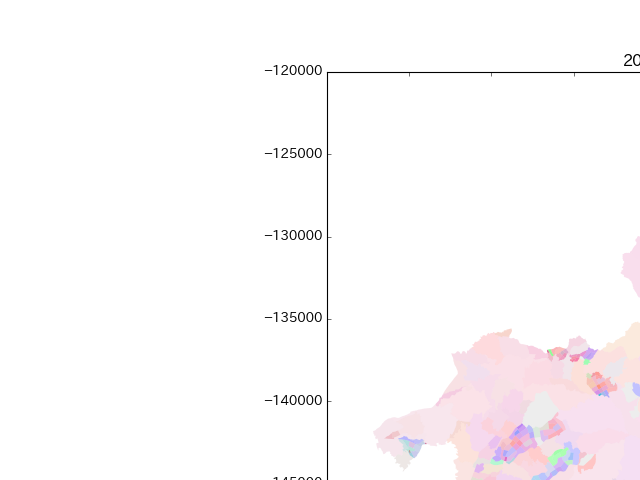

Index(['町名', '区・支所', '町コード', 'r', 'g', 'b', 'KEYCODE1'], dtype='object')
FILE: ../data/kobe/juuki1312.xls UNHANDLED IN 132      御影町郡家字寺ノ前
133      御影町郡家字堂ノ裏
134      御影町郡家字堂ノ前
136      御影町郡家字宮ノ浦
139     御影町西平野字一ノ坪
141     御影町西平野字ケジメ
145      御影町御影字上ノ山
149      御影町御影字城ノ前
150      御影町御影字滝ケ鼻
152    御影町御影字弓弦羽ノ森
Name: 町名, dtype: object
Index(['町名', '区・支所', '町コード', 'r', 'g', 'b', 'KEYCODE1'], dtype='object')
FILE: ../data/kobe/juuki1312.xls UNHANDLED IN 132      御影町郡家字寺ノ前
133      御影町郡家字堂ノ裏
134      御影町郡家字堂ノ前
136      御影町郡家字宮ノ浦
139     御影町西平野字一ノ坪
141     御影町西平野字ケジメ
145      御影町御影字上ノ山
149      御影町御影字城ノ前
150      御影町御影字滝ケ鼻
152    御影町御影字弓弦羽ノ森
Name: 町名, dtype: object
Index(['町名', '区・支所', '町コード', 'r', 'g', 'b', 'KEYCODE1'], dtype='object')
FILE: ../data/kobe/juuki1412.xls UNHANDLED IN 132      御影町郡家字寺ノ前
133      御影町郡家字堂ノ裏
134      御影町郡家字堂ノ前
136      御影町郡家字宮ノ浦
139     御影町西平野字一ノ坪
141     御影町西平野字ケジメ
145      御影町御影字上ノ山
149      御影町御影字城ノ前
150      御影町御影字滝ケ鼻
152    御影町御影字弓弦羽ノ森
Name: 町名, dtype: object
I

In [9]:
fig, ax1 = plt.subplots()
fig.set_size_inches(16,9)
ax1.set_aspect(1.0)
#ax1.set_xlim([70000, 85000])
#ax1.set_ylim([-155000, -140000])

def update(t):
    ax1.cla()
    title,zensi_name,estat_name=fns[t]
    ax1.title.set_text(title)
    g,c3 = proc(zensi_name,estat_name)
    _ = g.plot(column="idx", cmap=matplotlib.colors.ListedColormap(c3), alpha=None, linewidth=0, ax=ax1)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=range(len(fns)), interval=100, repeat_delay=500)
Writer = matplotlib.animation.writers["ffmpeg"]
ani.save("../docs/data/2016-10-08-pop-map.mp4", dpi=120,
    writer=Writer(fps=6, codec="libx264", bitrate=1800,
    extra_args=["-profile:v", "baseline", "-pix_fmt","yuv420p"]))